# Waves simulation Notebook 6

## Introduction

In this notebook we will solve, using the **finite difference method**, the **acustic (scalar) wave equation in one dimension** (where $x\in \mathbb{R}$), given by $$\partial_t^2 p-c^2 \partial_x^2 p +s=0 $$ where $p=p(x,t)$ is the preassure, $c=c(x)$ is (the square root of) the propagation velocity (time independent) and $s=s(x,t)$ is a surce term. This equation is well known, it descirbes, for example, the propagation of sound waves in an isotropic medium (e.g. air). 

The main idea we will use is **discretization**, where $x_j=jdx$ and $t_n=ndt$ for $j,n\in \mathbb{Z}$. As a consequence the preassure field $p=p(x,t)$ will also be discretized as $p_j^n=p(x_j,t_n)$, and the other continuous quantities will result discretized in a similar way. Recalling what we've seen in the previous notebooks about derivatives, we have the discertized equation $$\frac{p_j^{n+1}-2p_j^{n}+p_j{n-1}}{dt^2}=c^2\frac{p_{j+1}^{n}-2p_j^{n}+p_{j-1}{n}}{dx^2}+ s_j^n$$ and we extrapolate the preassure $$p_j^{n+1}= c_j^2\frac{dt^2}{dx^2}\Bigl[p_{j+1}^n-2p_j^n+p_{j-1}^n\Bigr]+2p_j^n-p_j^{n-1}+dt^2s_j^n$$ to have an explicit solution scheme (with initial contitions and/or boundary conditions, where also the surce term will often be assumed to be a $\delta$-function). A key problem will then be to find good discretizations. For example in we study the propagation of sound waves in air we have $$c=\frac{\lambda}{T}=\lambda f\sim 343 ms^{-1} $$ where $f$ is the frequency and $\lambda$ the wave-lenght. With tis in mind if $f=50 Hz$ then $\lambda=7m$ and we can use this information to properly initialize our simulations (cfr. Notebook 2).

To summarize, in this notebook we will carry out the following tasks:

* Implementation of the 1D acoustic wave equation 
* Understanding the input parameters for the simulation and the plots that are generated, and the related concept of numerical dispersion
* Understanding the concepts of stability and exploding solutions
* Modifying source and receiver locations and observing the effects on the seismograms


## Numerical simulations

In [1]:
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In the following parameter configuration we need to choose carefully the source term. In practice it is common to choose $s$ as the first derivative of a gaussian, where it appears an important term $f_0$ called *dominant frequency*. To avoid numerical dispersion the parameter $f_0$ must be properly tuned (also w.r.t. the physical surce studied). We will need to investigate this aspect further. Also by changing the parameter $dt$ we can observe exploding solutions and this will be a crucial problem we will solve in the next notebook.

In [2]:
# Parameter Configuration 
# -----------------------

nx   = 10000        # number of grid points in x-direction
xmax = 10000        # physical domain (m)
dx   = xmax/(nx-1)  # grid point distance in x-direction
c0   = 334.         # wave speed in medium (m/s)
isrc = int(nx/2)    # source location in grid in x-direction
#ir   = isrc + 100          # receiver location in grid in x-direction
nt   = 1001         # maximum number of time steps
dt   = 0.0010       # time step

# Source time function parameters
f0   = 15. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift

# Snapshot
idisp = 5 # display frequency

In [3]:
# Plot Source Time Function
# -------------------------

# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -8. * (time - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2))



<IPython.core.display.Javascript object>


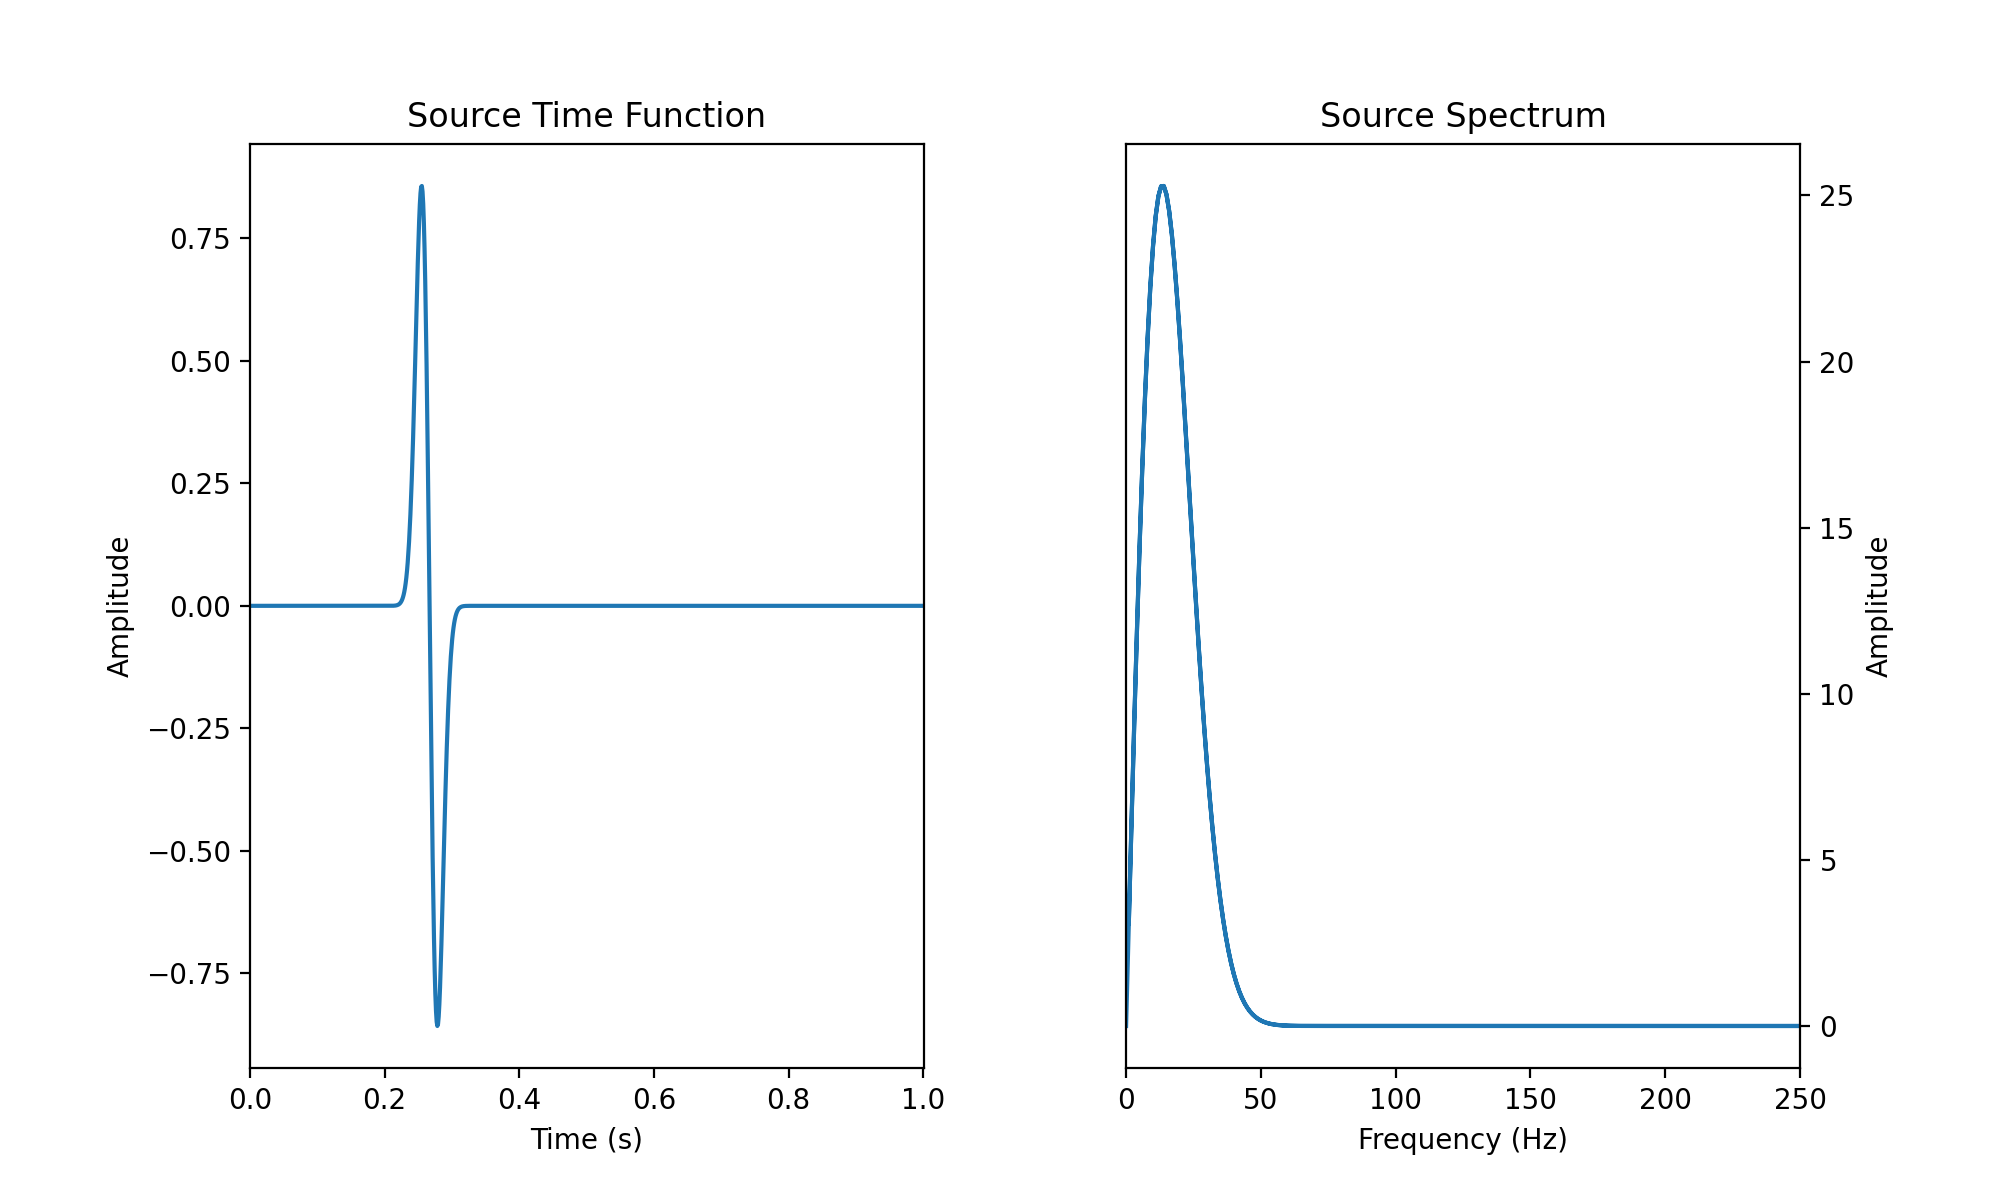

In [4]:
# Plot source time function

# Plot position configuration
# ---------------------------
plt.ion()
fig1 = plt.figure(figsize=(10, 6))
gs1  = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot source time function
# -------------------------
ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot source spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt ) # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

<IPython.core.display.Javascript object>


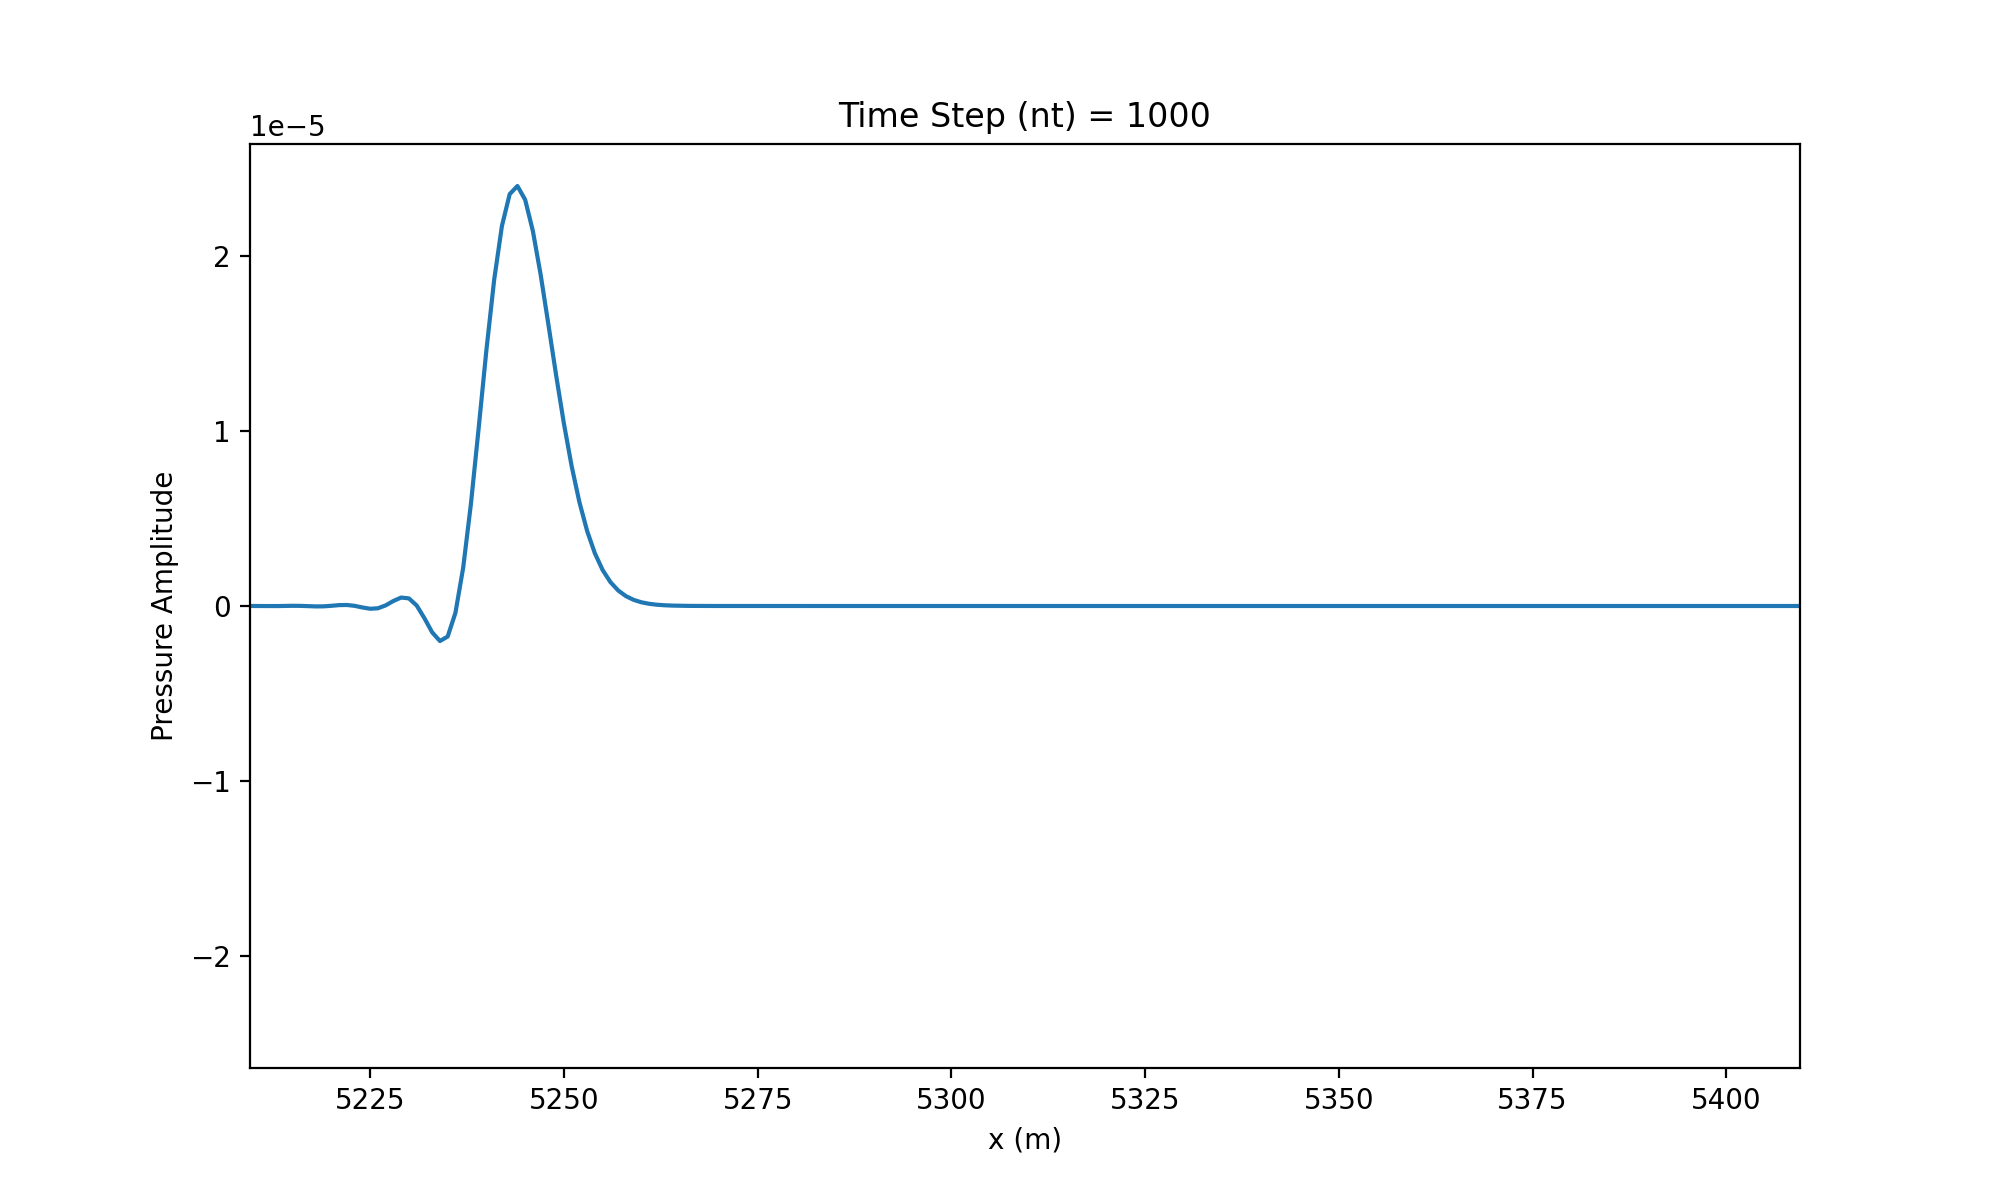

In [7]:
# Plot Snapshot & Seismogram 
# ---------------------------------------------------------------------------

# Initialize empty pressure
# -------------------------
p    = np.zeros(nx) # p at time n (now)
pold = np.zeros(nx) # p at time n-1 (past)
pnew = np.zeros(nx) # p at time n+1 (present)
d2px = np.zeros(nx) # 2nd space derivative of p

# Initialize model (assume homogeneous model)
# -------------------------------------------
c    = np.zeros(nx)
c    = c + c0       # initialize wave velocity in model

# Initialize coordinate
# ---------------------
x    = np.arange(nx)
x    = x * dx       # coordinate in x-direction


# Plot position configuration
# ---------------------------
plt.ion()
fig2  = plt.figure(figsize=(10, 6))
gs2   = gridspec.GridSpec(1,1,width_ratios=[1],hspace=0.3, wspace=0.3)

# Plot 1D wave propagation
# ------------------------
# Note: comma is needed to update the variable
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isrc, 0, 'r*', markersize=11) # plot position of the source in snapshot
#leg2,= ax3.plot(ir, 0, 'k^', markersize=8) # plot position of the receiver in snapshot
up31,= ax3.plot(p) # plot pressure update each time step
ax3.set_xlim(0, xmax)
ax3.set_ylim(-np.max(p), np.max(p))
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlabel('x (m)')
ax3.set_ylabel('Pressure Amplitude')
#ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)


plt.show()

In [8]:
# 1D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------

# Loop over time
for it in range(nt):

    # 2nd derivative in space
    for i in range(1, nx - 1):
        d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2


    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px

    # Add Source Term at isrc
    # -----------------------
    # Absolute pressure w.r.t analytical solution
    pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2
    
            
    # Remap Time Levels
    # -----------------
    pold, p = p, pnew
    
    # Plot pressure field
    # -------------------------------------
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        ax3.set_ylim(-1.1*np.max(abs(p)), 1.1*np.max(abs(p)))
        # plot around propagating wave
        window=100;xshift=25
        ax3.set_xlim(isrc*dx+c0*it*dt-window*dx-xshift, isrc*dx+c0*it*dt+window*dx-xshift)
        up31.set_ydata(p)
        plt.gcf().canvas.draw()

## Conclusions

* We've simulated the 1D acustic wave equation with the finite-difference method
* We've observed numerical dispersion by running the simulation with different wave lengths (the numerical dispersion starts to be evident with frequencies of 15 Hz or more).
* We've observed exploding solutions with different time discretizations.
* We'll need to find more stable algorithms...